In [1]:
pip install altair

You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
from dwdbulk.api import observations
from dwdbulk.util import get_stations_lookup

In [4]:
resolution = "10_minutes"
parameter = "air_temperature"

date_end = pd.Timestamp.now(tz="UTC").floor("h")
date_start = date_end - pd.Timedelta("7 days")

In [5]:
df = observations.get_data(
    parameter,
    date_start=date_start,
    date_end=date_end,
    resolution=resolution,
)

In [6]:
weather_rollup = df.groupby("date_start", as_index=False) \
    .TT_10.aggregate([lambda x: pd.Series.quantile(x, q=1/8),
                      lambda x: pd.Series.quantile(x, q=3/8),
                      lambda x: pd.Series.quantile(x, q=4/8),
                      lambda x: pd.Series.quantile(x, q=5/8),                      
                      lambda x: pd.Series.quantile(x, q=7/8)])

In [7]:
weather_rollup = weather_rollup.reset_index()
weather_rollup.columns = ["date_start", "quantile_0_125", "quantile_0_375", "quantile_0_5", "quantile_0_625", "quantile_0_875"]


In [8]:
weather_rollup.head()

,date_start,quantile_0_125,quantile_0_375,quantile_0_5,quantile_0_625,quantile_0_875
0,2019-08-23 14:00:00+00:00,22.2,24.9,26.2,27.0,28.2
1,2019-08-23 14:10:00+00:00,22.1,25.0,26.2,27.0,28.2
2,2019-08-23 14:20:00+00:00,22.3,25.0,26.2,27.0,28.3
3,2019-08-23 14:30:00+00:00,22.2,25.0,26.2,27.0,28.3
4,2019-08-23 14:40:00+00:00,22.2,24.9,26.2,27.0,28.3


In [9]:
import altair as alt

p_range_1 = alt.Chart(weather_rollup).mark_area(opacity=0.25).encode(
    x=alt.X('date_start:T', axis=alt.Axis(title="Date")),
    y=alt.Y("quantile_0_125", axis=alt.Axis(title="°C"), scale=alt.Scale(zero=False)),
    y2="quantile_0_875"
)

p_range_2 = alt.Chart(weather_rollup).mark_area(opacity=0.5).encode(
    x='date_start:T',
    y="quantile_0_375",
    y2="quantile_0_625"
)

p_median = alt.Chart(weather_rollup).mark_line().encode(
    x='date_start:T',
    y=alt.Y("quantile_0_5", axis=alt.Axis(title="°C"), scale=alt.Scale(zero=False)),
)


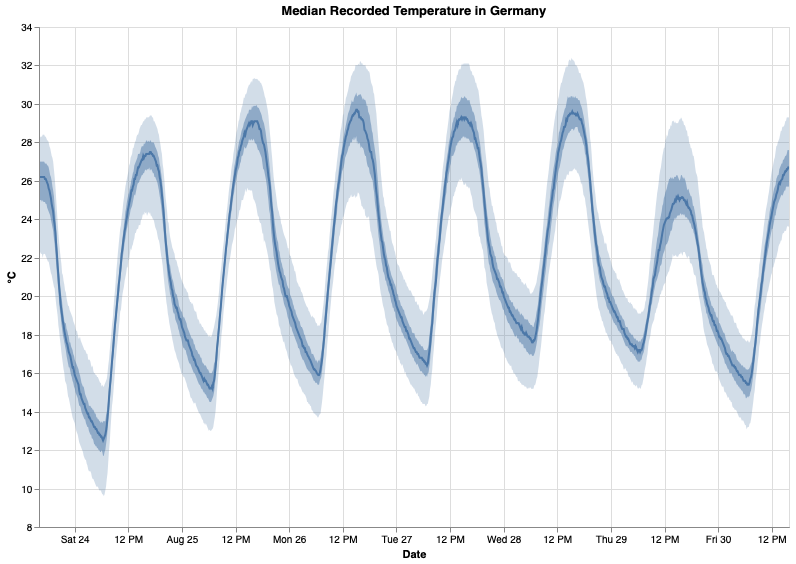

In [10]:
(p_range_1 + p_range_2 + p_median) \
    .configure_view(height=500, width=750) \
    .properties(title="Median Recorded Temperature in Germany")

In [11]:
df_stations = observations.get_stations(resolution, parameter)

In [12]:
# Subset stations with data
df_stations = df_stations[df_stations.station_id.isin(df.station_id.tolist())]

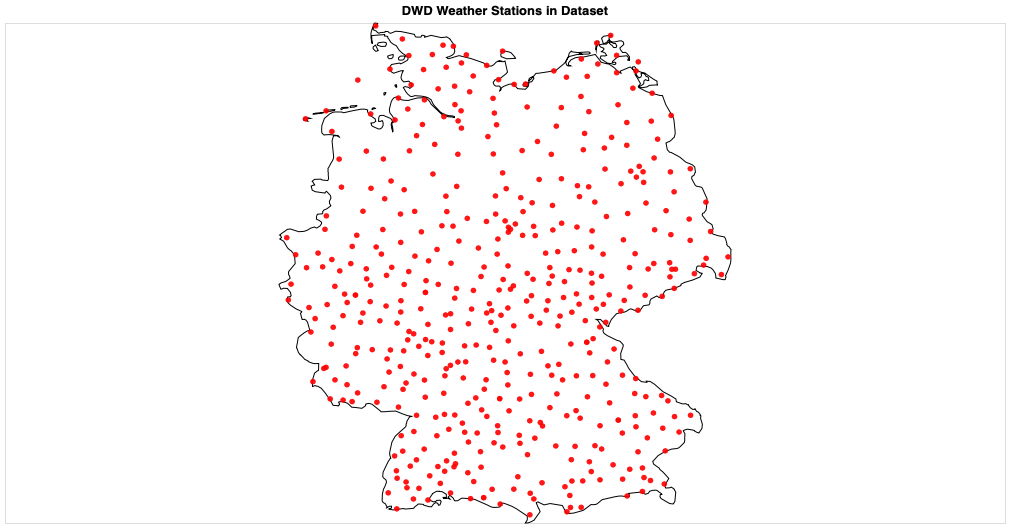

In [15]:
eu_boundaries_url = "https://raw.githubusercontent.com/leakyMirror/map-of-europe/master/TopoJSON/europe.topojson"
eu_boundaries = alt.topo_feature(eu_boundaries_url, 'europe')


eu_map = alt.Chart(eu_boundaries).mark_geoshape(color="black", filled=False).project(
    type='azimuthalEqualArea'
) \
.transform_filter((alt.datum.id)=='DE') \
.properties(
    width=1000,
    height=500
)

points = alt.Chart(df_stations).mark_circle().encode(
    longitude='geo_lon:Q',
    latitude='geo_lat:Q',
    color=alt.value('red'),
    tooltip=['name:N','state', 'date_start', 'date_end']
).properties(
    title='DWD Weather Stations in Dataset'
)

points
eu_map + points